<h1>Baseline Tests</h1>

Conduct simple proof-of-concept test to verify the correctness of algorithmic implementations for the following algorithms: 

1. NSR (no swap regrets)
1. RL (reinforcement learning)

### imports

In [3]:
import sys, os 
import numpy as np
sys.path.append(os.path.abspath(".."))
from market_core import DuopolyEnv 
import matplotlib.pyplot as plt
import seaborn as sns
from utils import run_episode, plot_generalized_convergence
from agent_zoo import NSRAgent, FixedPriceAgent, RandomAgent, RLAgent

## Static Market

Market inputs: 

1. demand std: 0
1. price sensitivity: 0.8
1. max price: 10 
1. firm 1 cost: 1 
1. firm 2 cost: 2 
1. brand quality: 2.0 for both 

In [13]:
env_config = {
    'market_mode': 'static',
    'production_costs': [1.0, 2.0],
    'quality': [5.0, 5.0],
    'price_sensitivity': 0.8, # Back to standard sensitivity
    'max_price': 8.0,
    'cost_std': 0.0,
    'max_steps': 10000
} 
nsr_config = {
    'n_bins': 100,
    'learning_rate': 0.01,
    'quality': 5.0,           # Must match env
    'price_sensitivity': 0.8, # Must match env
    'cost': 1.0               # Agent 1's cost
}
rl_config = {
    'state_dim': 5,          # Dimension of observation space (must match env)
    'hidden_dim': 128,        # Neural network hidden size
    'n_bins': 100,           # Number of discrete price actions
    'lr': 5e-5,              # Learning rate
    'gamma': 0.99,           # Discount factor
    'epsilon': 1.0,          # Initial exploration rate
    'epsilon_decay': 0.99,  # Exploration decay per step
    'epsilon_min': 0.01,     # Minimum exploration rate
    'batch_size': 64,        # Training batch size
    'memory_size': 2000,     # Replay buffer size
}
fixed_config = {'fixed_price':2.5}
random_config = {'max_price':8.0}

In [14]:
env = DuopolyEnv(config=env_config)
nsr_agent = NSRAgent(action_space=env.action_space,config=nsr_config)
fixed_agent = FixedPriceAgent(action_space=env.action_space,config=fixed_config)
random_agent = RandomAgent(action_space=env.action_space,config=random_config)

### NSR (No Swap Regret)

In [15]:
nsr_fixed_history = run_episode(env, nsr_agent, fixed_agent, label='NSR vs Fixed', train_mode=True)
nsr_random_history = run_episode(env, nsr_agent, random_agent, label="NSR vs Random", train_mode=True)

In [16]:
print("The average final price after learning for 1000 steps (last 100 steps) of nsr vs fixed: ", np.mean(nsr_fixed_history['p1'][-100:]))
print("The average final price after learning for 1000 steps (last 100 steps) of nsr vs random: ", np.mean(nsr_random_history['p1'][-100:]))

The average final price after learning for 1000 steps (last 100 steps) of nsr vs fixed:  2.989899
The average final price after learning for 1000 steps (last 100 steps) of nsr vs random:  4.121212


Average best price P1: 3.027027027027028
Average best price P2: 3.850162962962962


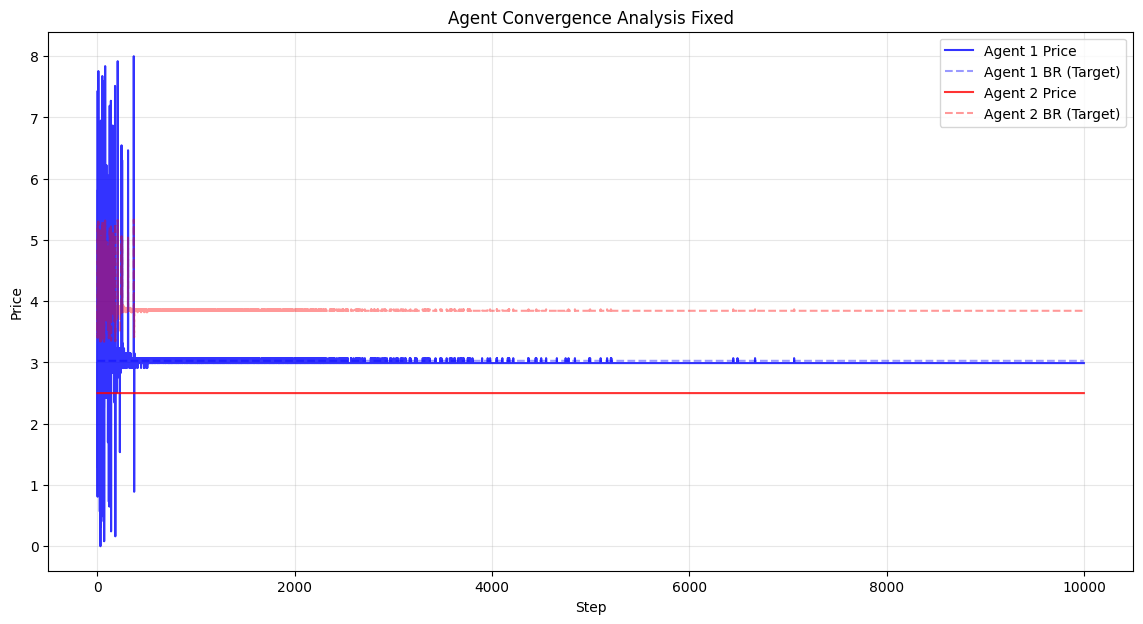

In [17]:
plot_generalized_convergence(nsr_fixed_history, env_config, title_suffix="Fixed")

Average best price P1: 3.6772532532532534
Average best price P2: 4.215517917917918


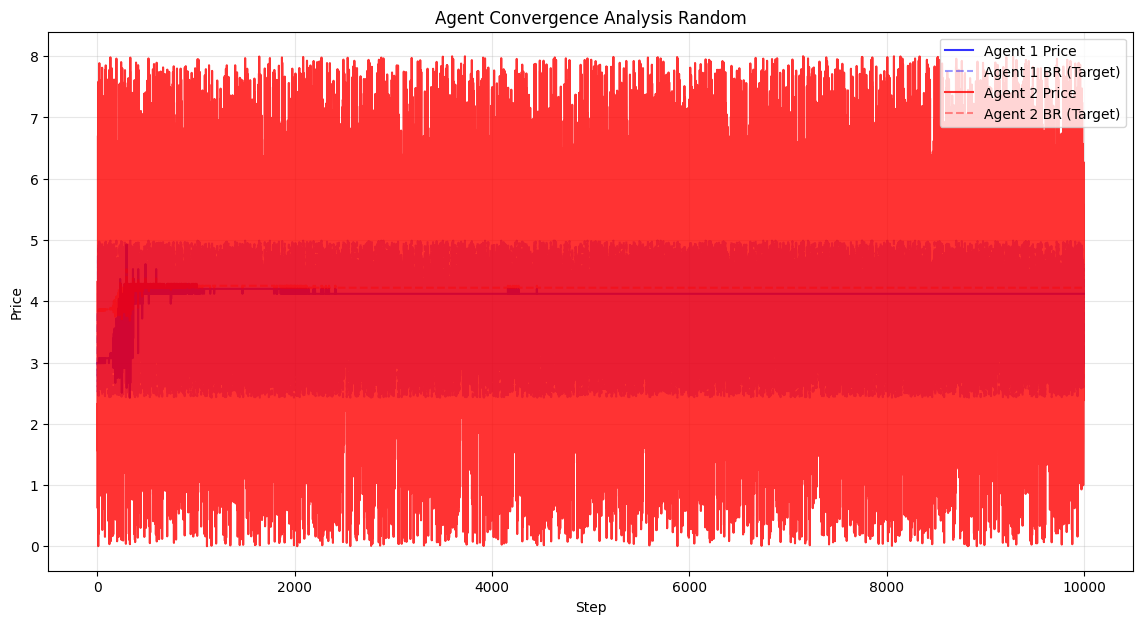

In [18]:
plot_generalized_convergence(nsr_random_history, env_config, title_suffix="Random")

### RL Agent

In [4]:
rl_agent1 = RLAgent(action_space=env.action_space, config=rl_config)
rl_agent2 = RLAgent(action_space=env.action_space, config=rl_config)

In [5]:
rl_fixed_history_tr = run_episode(env, rl_agent1, fixed_agent, label='RL vs Fixed')
rl_fixed_history_ts = run_episode(env, rl_agent1, fixed_agent, label="RL vs Fixed eval", train_mode=False)
rl_random_history_tr = run_episode(env, rl_agent2, random_agent, label="RL vs Random")
rl_random_history_ts = run_episode(env, rl_agent2, random_agent, label="RL vs Random eval", train_mode=False)

In [7]:
print("The average final price after learning for 10000 steps (last 100 steps) of rl vs fixed: ", np.mean(rl_fixed_history_ts['p1'][-100:]))
print("The average final price after learning for 10000 steps (last 100 steps) of rl vs random: ", np.mean(rl_random_history_ts['p1'][-100:]))

The average final price after learning for 10000 steps (last 100 steps) of rl vs fixed:  2.6060605
The average final price after learning for 10000 steps (last 100 steps) of rl vs random:  3.0969696


Average best price: 2.7567567567567575


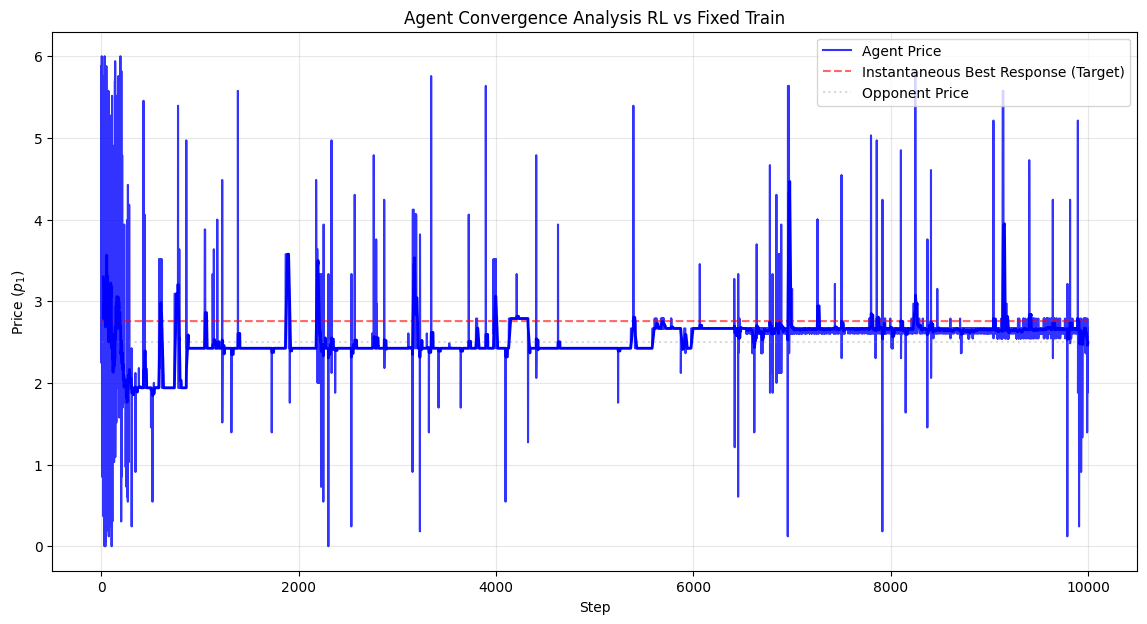

In [8]:
plot_generalized_convergence(rl_fixed_history_tr, env_config, title_suffix="RL vs Fixed Train")

Average best price: 2.7567567567567575


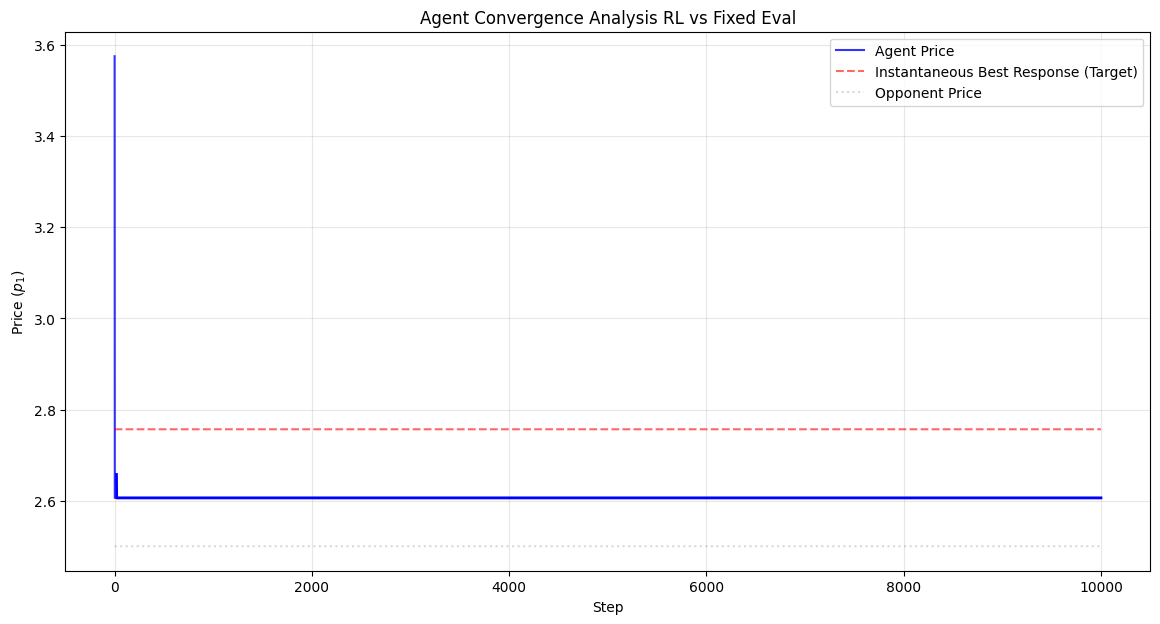

In [10]:
plot_generalized_convergence(rl_fixed_history_ts, env_config, title_suffix="RL vs Fixed Eval")

Average best price: 2.7802576576576574


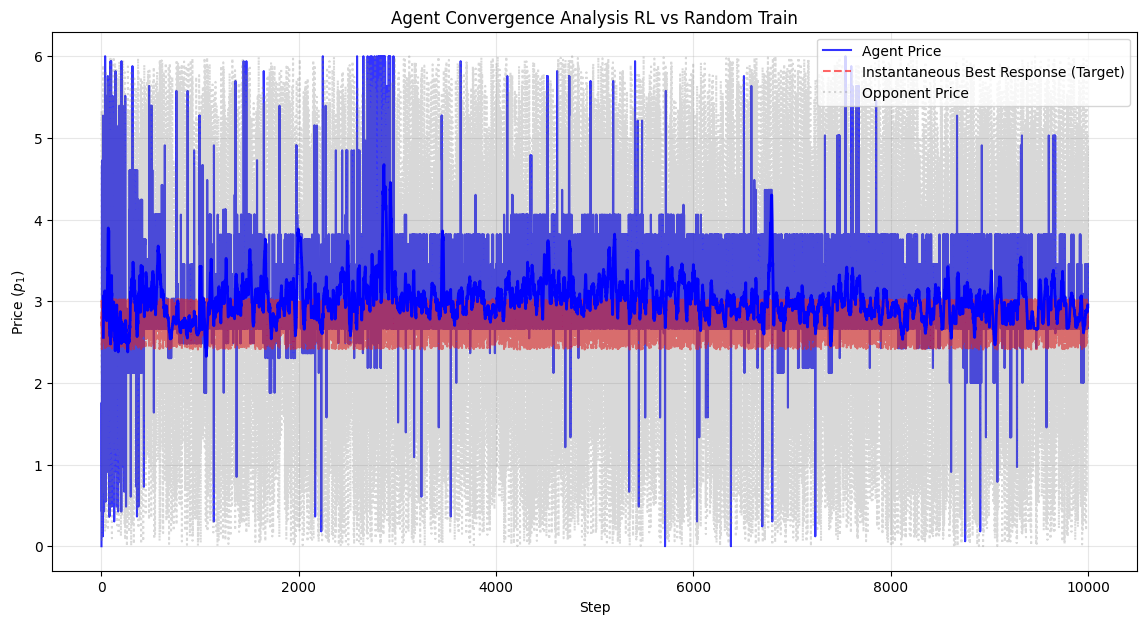

In [11]:
plot_generalized_convergence(rl_random_history_tr, env_config, title_suffix="RL vs Random Train")

Average best price: 2.7791873873873874


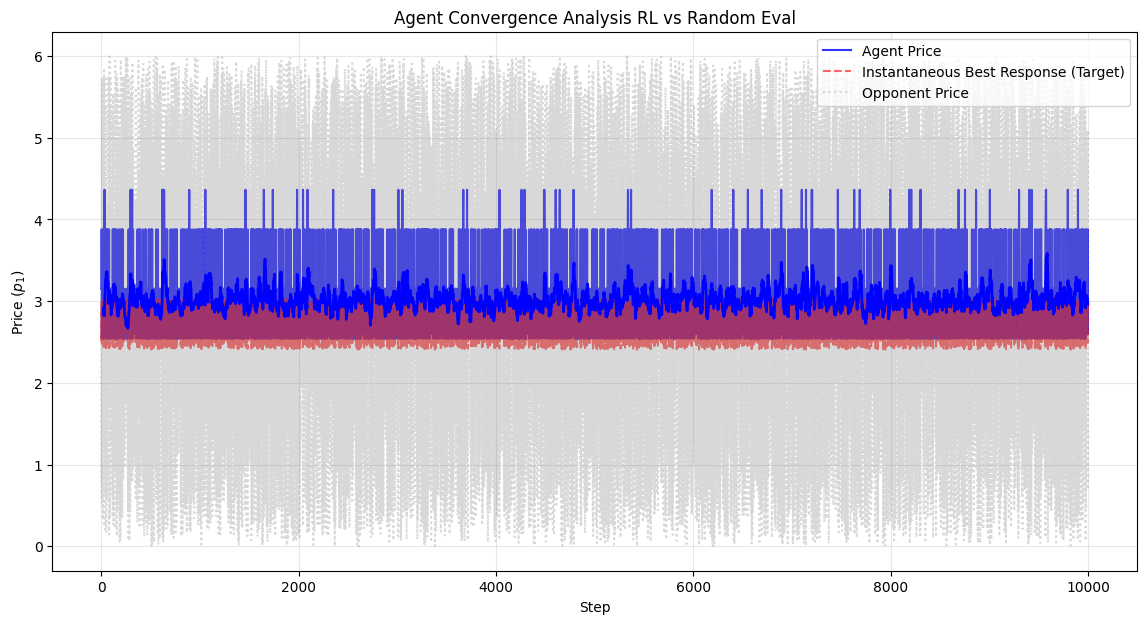

In [146]:
plot_generalized_convergence(rl_random_history_ts, env_config, title_suffix="RL vs Random Eval")

## Dynamic Market (AR (1))